## QTLs mapped on coexpressed cluster PCs (pcQTLs) colocalize with new GWAS signals


In [9]:
import numpy as np
import pandas as pd
from pandas.errors import EmptyDataError  # Import EmptyDataError
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import ast
from scipy.stats import ttest_rel, ranksums
import networkx as nx
import os


from tqdm.auto import tqdm 
tqdm.pandas()

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

In [10]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

gwas_meta = pd.read_csv(config['gwas_meta'], sep='\t', header=0)
gwas_ids = gwas_meta['Tag']
coloc_cutoff = .75

### load in gwas coloc results

In [ ]:
# recursively get list of files ending with .qtl_gwas.txt
def get_files(directory):
    file_list = []
    for root, directories, files in os.walk(directory):
        if not 'temp' in root:
            for file in files:
                if "susie_True" in file:
                    file_list.append(os.path.join(root, file))
    return file_list
coloc_file_list = get_files('{}/{}'.format(prefix, config["coloc_output_dir"] + "gwas"))

# Load each file into a DataFrame and concatenate them
cluster_colocs = []
for cluster_file in tqdm(coloc_file_list):
    try:
        cluster_coloc = pd.read_csv(cluster_file, sep='\t')  # Assuming tab-separated file
    except EmptyDataError as e:
        print(f"File is empty: {cluster_file}") 
    tissue_id = cluster_file.split('/')[9]
    cluster_coloc['tissue_id'] = tissue_id
    cluster_colocs.append(cluster_coloc)

# Concatenate all DataFrames into a single DataFrame
gwas_coloc = pd.concat(cluster_colocs, ignore_index=True)
# drop duplicate rows from intermediate write outs
gwas_coloc = gwas_coloc.drop_duplicates()

  0%|          | 0/1353 [00:00<?, ?it/s]

File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.EGG_Pubertal_growth_10F.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.GEFOS_Forearm.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.UKB_G43_Diagnoses_main_ICD10_G43_Migraine.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.GPC-NEO-NEUROTICISM.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.PGC_ASD_2017_CEU.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/

In [47]:
# add information to dataframe
gwas_coloc['cluster_id'] = np.where(gwas_coloc['qtl_id'].str.contains('_e'), gwas_coloc['qtl_id'].str.split('_e').str[0], gwas_coloc['qtl_id'].str.split('_pc').str[0])
# make ids for each credible set in the qtl and gwas
gwas_coloc['gwas_cs_id'] = gwas_coloc['gwas_id'] + '_cs_' + gwas_coloc['gwas_cs_is'].astype(int).astype(str) + '_cluster_' + gwas_coloc['cluster_id']
gwas_coloc['qtl_cs_id'] = gwas_coloc['qtl_id'] + '_cs_' + gwas_coloc['qtl_cs_is'].astype(int).astype(str) + '_cluster_' + gwas_coloc['cluster_id']
# set type as pcqtl or eqtl
gwas_coloc['type'] = np.where(gwas_coloc['qtl_cs_id'].str.contains('_pc'), 'pcqtl', 'eqtl')
# fill in nas with 0
gwas_coloc[['PP.H0.abf', 'PP.H1.abf', 'PP.H2.abf', 'PP.H3.abf', 'PP.H4.abf']] = gwas_coloc[['PP.H0.abf', 'PP.H1.abf', 'PP.H2.abf', 'PP.H3.abf', 'PP.H4.abf']].fillna(0)

# add tissue specific ids
gwas_coloc['gwas_tissue_cs_id'] = 'gwas_' + gwas_coloc['gwas_cs_id'] + '_tissue_' + gwas_coloc['tissue_id']
gwas_coloc['qtl_tissue_cs_id'] = 'qtl_' + gwas_coloc['qtl_cs_id'] + '_tissue_' + gwas_coloc['tissue_id']

### aggregate over all PCs and egene for each cluster

get the maximum coloc probability for each GWAS credible set with any egene or PC in the cluster

In [42]:
# aggregate over egenes and pcs
gwas_coloc_e = gwas_coloc[gwas_coloc['type']=='eqtl']
gwas_coloc_pc = gwas_coloc[gwas_coloc['type']=='pcqtl']
max_pph4_indices_e = gwas_coloc_e.groupby('gwas_cs_id')['PP.H4.abf'].idxmax()
max_pph4_indices_pc = gwas_coloc_pc.groupby('gwas_cs_id')['PP.H4.abf'].idxmax()

# set the pp4 to be the max of any pc or egene in the cluster
eqtl_pp4 = gwas_coloc.loc[max_pph4_indices_e, ['gwas_cs_id', 'PP.H4.abf']]
pcqtl_pp4 = gwas_coloc.loc[max_pph4_indices_pc, ['gwas_cs_id', 'PP.H4.abf']]
pph4 = pd.merge(pcqtl_pp4, eqtl_pp4, suffixes=['_pc','_e'], left_on='gwas_cs_id', right_on='gwas_cs_id', how='outer')
pph4['colocalized'] = (pph4['PP.H4.abf_e'] > coloc_cutoff)| (pph4['PP.H4.abf_pc'] >coloc_cutoff )
pph4['coloc_color'] = np.where(pph4['PP.H4.abf_e'] > coloc_cutoff, 
                               np.where(pph4['PP.H4.abf_pc'] >coloc_cutoff, 'Both', 'eQTL only'),
                               np.where(pph4['PP.H4.abf_pc'] >coloc_cutoff, 'pcQTL only', 'Neither'))

# print the percent in each category
print('pc only:{}'.format(((pph4['PP.H4.abf_pc']>coloc_cutoff) & (pph4['PP.H4.abf_e']<coloc_cutoff)).sum()/sum(pph4['colocalized'])))
print('e only:{}'.format(((pph4['PP.H4.abf_e']>coloc_cutoff) & (pph4['PP.H4.abf_pc']<coloc_cutoff)).sum()/sum(pph4['colocalized'])))
print('both: {}'.format(((pph4['coloc_color']=='Both')).sum()/sum(pph4['colocalized'])))
print('neither: {}'.format(((pph4['coloc_color']=='Neither')).sum()/len(pph4)))

pc only:0.20785219399538107
e only:0.26096997690531176
both: 0.5050038491147036
neither: 0.981110400186133


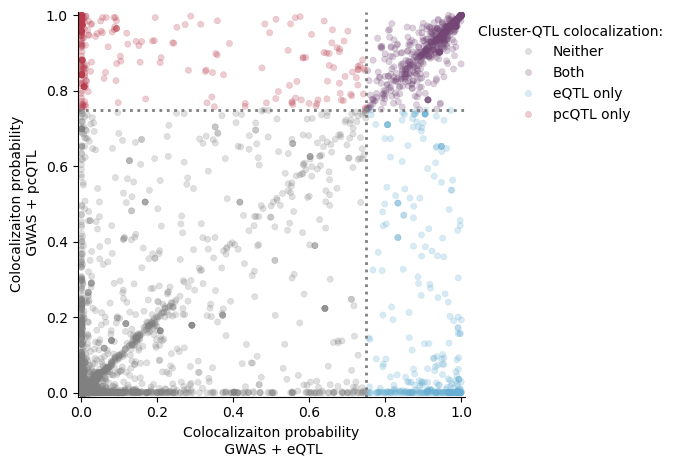

In [45]:
# plot th pp4s
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(pph4[pph4['coloc_color'].isin(['Neither', 'Both', 'eQTL only', 'pcQTL only'])], x='PP.H4.abf_e', y='PP.H4.abf_pc', hue='coloc_color', ax=ax, s=20, alpha=.25,
             palette={'pcQTL only':'#B83A4B', 'eQTL only':'#67AFD2', 'Both':'#734675', 'Neither':'grey'}, edgecolor=None,
             hue_order = ['Neither', 'Both', 'eQTL only', 'pcQTL only'])
ax.axhline(.75, color='grey', linestyle=':', linewidth=2)
ax.axvline(.75, color='grey', linestyle=':', linewidth=2)

ax.set_xlabel('Colocalizaiton probability\n GWAS + eQTL')
ax.set_ylabel('Colocalizaiton probability\n GWAS + pcQTL')

ax.set_xlim(-.01, 1.01)
ax.set_ylim(-.01,1.01)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('Cluster-QTL colocalization: ')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

### number of 

In [30]:
# count number of e and pc hits
gwas_coloc_hits = gwas_coloc[gwas_coloc['PP.H4.abf'] > coloc_cutoff].reset_index()
print('number pcqtls total (could overlap): {}'.format(sum(gwas_coloc_hits['qtl_cs_id'].str.contains('_pc'))))
print('number eqtls total (could overlap): {}'.format(sum(gwas_coloc_hits['qtl_cs_id'].str.contains('_e'))))

number pcqtls total (could overlap): 1665
number eqtls total (could overlap): 1851


In [31]:
# each tissue has different clusters, so it doesn't really make any sense to compare across tissues. 
# we add tissue to the id so that signal grouping is done on a per-tissue level
gwas_coloc_hits['gwas_tissue_cs_id'] = 'gwas_' + gwas_coloc_hits['gwas_cs_id'] + '_tissue_' + gwas_coloc_hits['tissue_id']
gwas_coloc_hits['qtl_tissue_cs_id'] = 'qtl_' + gwas_coloc_hits['qtl_cs_id'] + '_tissue_' + gwas_coloc_hits['tissue_id']

In [70]:
# Create an undirected graph
G = nx.Graph()
# add an edge for each gwas-qtl coloc
for index, row in gwas_coloc_hits.iterrows():
    G.add_edge(row['gwas_tissue_cs_id'], row['qtl_tissue_cs_id'])
 # Get the connected components of the graph
connected_components = list(nx.connected_components(G))
# Generate underlying signal ids
underlying_signals = ['-'.join(sorted(component)) for component in connected_components]

# make a df
underlying_signals = pd.DataFrame({'signal_id':underlying_signals})
underlying_signals['num_qtl_coloc'] = underlying_signals['signal_id'].astype(str).str.count('qtl_')
underlying_signals['num_gwas_coloc'] = underlying_signals['signal_id'].astype(str).str.count('gwas_')
underlying_signals['num_e_coloc'] = underlying_signals['signal_id'].astype(str).str.count('_e_')
underlying_signals['num_pc_coloc'] = underlying_signals['signal_id'].astype(str).str.count('_pc')
underlying_signals['multiple_e'] = underlying_signals['num_e_coloc'] > 1
underlying_signals['multiple_pc'] = underlying_signals['num_pc_coloc'] > 1

underlying_signals['type'] = np.where(underlying_signals['num_pc_coloc']>0, np.where(underlying_signals['num_e_coloc']>0, 'both', 'pcqtl_only'), 'eqtl_only')
underlying_signals['cluster_id'] = underlying_signals['signal_id'].str.split('_cluster_').str[1].str.split('_tissue_').str[0]

# Count the number of gwas types
underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')
underlying_signals_explode = underlying_signals.explode('cs_id')
underlying_signals_explode_gwas = underlying_signals_explode[underlying_signals_explode['cs_id'].str.contains('gwas_')]
underlying_signals_explode_gwas['gwas_type'] = underlying_signals_explode_gwas['cs_id'].str.split('gwas_').str[1].str.split('_cs').str[0]
underlying_signals = pd.merge(underlying_signals, underlying_signals_explode_gwas.groupby('signal_id').agg({'gwas_type':'nunique'}), on='signal_id')

/local/scratch/klawren/slrmtmp.47429141/ipykernel_43925/3227994857.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals_explode_gwas['gwas_type'] = underlying_signals_explode_gwas['cs_id'].str.split('gwas_').str[1].str.split('_cs').str[0]


In [133]:
underlying_signals

,signal_id,num_qtl_coloc,num_gwas_coloc,num_e_coloc,num_pc_coloc,multiple_e,multiple_pc,type,cluster_id,cs_id,gwas_type
0,gwas_ADIPOGen_Adiponectin_cs_1_cluster_ENSG000...,1,6,1,0,False,False,eqtl_only,ENSG00000197653.15_ENSG00000250091.2,[gwas_ADIPOGen_Adiponectin_cs_1_cluster_ENSG00...,6
1,gwas_EAGLE_Eczema_cs_5_cluster_ENSG00000159516...,2,2,1,1,False,False,both,ENSG00000159516.8_ENSG00000163216.6_ENSG000001...,[gwas_EAGLE_Eczema_cs_5_cluster_ENSG0000015951...,1
2,gwas_EAGLE_Eczema_cs_1_cluster_ENSG00000115604...,1,1,0,1,False,False,pcqtl_only,ENSG00000115604.10_ENSG00000115607.9,[gwas_EAGLE_Eczema_cs_1_cluster_ENSG0000011560...,1
3,gwas_BCAC_ER_negative_BreastCancer_EUR_cs_1_cl...,3,1,2,1,True,False,both,ENSG00000115844.10_ENSG00000144355.14,[gwas_BCAC_ER_negative_BreastCancer_EUR_cs_1_c...,1
4,gwas_BCAC_ER_negative_BreastCancer_EUR_cs_1_cl...,2,2,1,1,False,False,both,ENSG00000152348.15_ENSG00000186468.12_ENSG0000...,[gwas_BCAC_ER_negative_BreastCancer_EUR_cs_1_c...,2
...,...,...,...,...,...,...,...,...,...,...,...
1175,gwas_UKB_23099_Body_fat_percentage_cs_2_cluste...,1,1,1,0,False,False,eqtl_only,ENSG00000139970.16_ENSG00000151838.11,[gwas_UKB_23099_Body_fat_percentage_cs_2_clust...,1
1176,gwas_GIANT_2017_BMI_Active_EUR_cs_2_cluster_EN...,1,2,0,1,False,False,pcqtl_only,ENSG00000103351.12_ENSG00000167984.17,[gwas_GIANT_2017_BMI_Active_EUR_cs_2_cluster_E...,2
1177,gwas_UKB_23099_Body_fat_percentage_cs_1_cluste...,1,1,0,1,False,False,pcqtl_only,ENSG00000278259.4_ENSG00000278311.4,[gwas_UKB_23099_Body_fat_percentage_cs_1_clust...,1
1178,gwas_UKB_23099_Body_fat_percentage_cs_2_cluste...,1,1,1,0,False,False,eqtl_only,ENSG00000109016.17_ENSG00000178307.9,[gwas_UKB_23099_Body_fat_percentage_cs_2_clust...,1


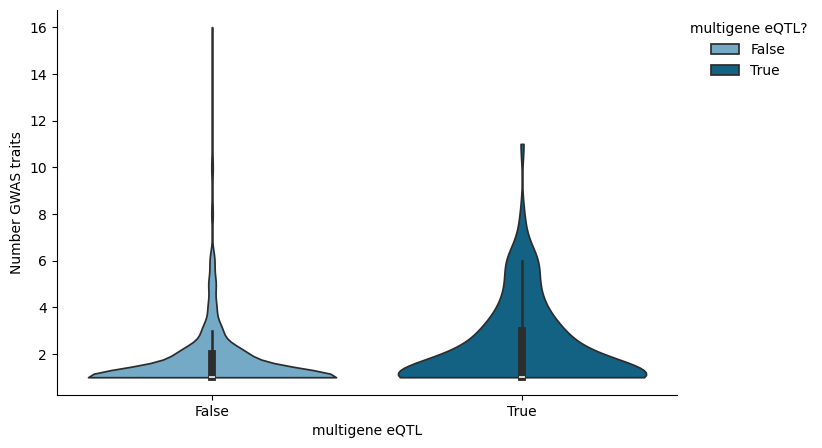

In [163]:
fig, ax = plt.subplots(figsize=(8,5))

sns.violinplot(underlying_signals[underlying_signals['num_e_coloc']>0], y='gwas_type', hue='multiple_e', x='multiple_e', 
               palette=('#67AFD2', '#016895'), ax=ax,cut=0)


ax.set_ylabel("Number GWAS traits")
ax.set_xlabel("multigene eQTL")

ax.legend(title="multigene eQTL?", loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

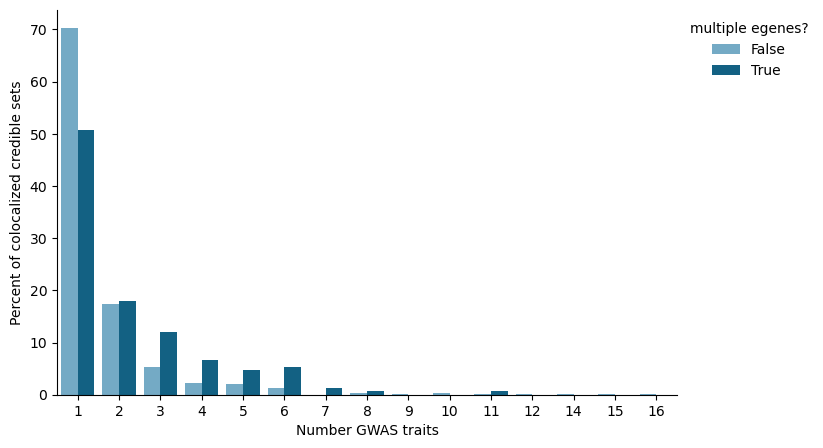

In [ ]:
# single gene vs multigene
data_to_plot = underlying_signals[underlying_signals['num_e_coloc']>0].groupby('multiple_e')['gwas_type'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data_to_plot, x='gwas_type',y='percent',hue='multiple_e',
            palette=('#67AFD2', '#016895'), ax=ax)

ax.set_xlabel("Number GWAS traits")
ax.set_ylabel("Percent of colocalized credible sets")

ax.legend(title="multiple egenes?", loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)